Importando os dados brutos


In [ ]:
#Importar os dados brutos

from google.colab import files
import pandas as pd

# Faça o upload do arquivo .csv
uploaded = files.upload()

# Carregue o arquivo .csv no pandas
csv_file_name = list(uploaded.keys())[0]
data = pd.read_csv(csv_file_name)

# Exiba as primeiras linhas do DataFrame para verificar o carregamento
print("Primeiras linhas dos dados:")
print(data.head())

# Exiba informações gerais sobre o DataFrame para verificar tipos de dados e valores ausentes
print("\nInformações gerais dos dados:")
print(data.info())

Saving aac_intakes_outcomes.csv to aac_intakes_outcomes.csv
Primeiras linhas dos dados:
  age_upon_outcome animal_id_outcome        date_of_birth outcome_subtype  \
0         10 years           A006100  2007-07-09 00:00:00             NaN   
1          7 years           A006100  2007-07-09 00:00:00             NaN   
2          6 years           A006100  2007-07-09 00:00:00             NaN   
3         10 years           A047759  2004-04-02 00:00:00         Partner   
4         16 years           A134067  1997-10-16 00:00:00             NaN   

      outcome_type sex_upon_outcome  age_upon_outcome_(days)  \
0  Return to Owner    Neutered Male                     3650   
1  Return to Owner    Neutered Male                     2555   
2  Return to Owner    Neutered Male                     2190   
3         Transfer    Neutered Male                     3650   
4  Return to Owner    Neutered Male                     5840   

   age_upon_outcome_(years) age_upon_outcome_age_group     outco

Transformando .csv em .parquet

In [ ]:
import pandas as pd

# Supondo que o DataFrame 'data' já está carregado do CSV
# Se você seguiu o código anterior, 'data' já está definido

# Defina o nome do arquivo Parquet
parquet_file_name = csv_file_name.replace('.csv', '.parquet')

# Salve o DataFrame como um arquivo Parquet
data.to_parquet(parquet_file_name, index=False)

print(f"Arquivo CSV foi convertido e salvo como {parquet_file_name}")

Arquivo CSV foi convertido e salvo como aac_intakes_outcomes.parquet


Iniciando a limpeza dos dados


In [ ]:
# Criação de uma cópia do DataFrame original para preservação dos dados brutos
data_cleaned = data.copy()

# Conversão de colunas com datas e horas para o tipo datetime, tratando erros e utilizando coerção
datetime_columns = ['date_of_birth', 'outcome_datetime', 'intake_datetime']

for col in datetime_columns:
    data_cleaned[col] = pd.to_datetime(data_cleaned[col], format='%d/%m/%Y %H:%M', errors='coerce')

# Reformatação de colunas que armazenam mês e ano, convertendo para o formato 'mm/yyyy'
monthyear_fields = ['dob_monthyear', 'outcome_monthyear', 'intake_monthyear']
for field in monthyear_fields:
    data_cleaned[field] = pd.to_datetime(data_cleaned[field], format='%Y-%m', errors='coerce').dt.strftime('%m/%Y')

# Transformação de colunas de mês em valores numéricos
month_fields = ['outcome_month', 'dob_month', 'intake_month']
for field in month_fields:
    data_cleaned[field] = pd.to_numeric(data_cleaned[field], errors='coerce')

# Conversão de colunas numéricas para garantir o tipo correto e tratamento de possíveis erros
numeric_fields = [
    'age_upon_outcome_(days)', 'age_upon_outcome_(years)', 'outcome_year', 'outcome_hour',
    'outcome_number', 'dob_year', 'age_upon_intake_(days)', 'age_upon_intake_(years)',
    'intake_year', 'intake_hour', 'intake_number', 'time_in_shelter_days'
]
for field in numeric_fields:
    data_cleaned[field] = pd.to_numeric(data_cleaned[field], errors='coerce')

# Exibição das informações gerais do DataFrame após a limpeza e conversão dos dados
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79672 entries, 0 to 79671
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   age_upon_outcome            79672 non-null  object        
 1   animal_id_outcome           79672 non-null  object        
 2   date_of_birth               0 non-null      datetime64[ns]
 3   outcome_subtype             36348 non-null  object        
 4   outcome_type                79662 non-null  object        
 5   sex_upon_outcome            79671 non-null  object        
 6   age_upon_outcome_(days)     79672 non-null  int64         
 7   age_upon_outcome_(years)    79672 non-null  float64       
 8   age_upon_outcome_age_group  79672 non-null  object        
 9   outcome_datetime            0 non-null      datetime64[ns]
 10  outcome_month               79672 non-null  int64         
 11  outcome_year                79672 non-null  int64     

In [ ]:
# Verificar valores ausentes
missing_values = data_cleaned.isnull().sum()

print("Valores ausentes por coluna:")
print(missing_values[missing_values > 0])

# Verificar duplicatas
duplicate_rows = data_cleaned.duplicated().sum()

print(f"\nNúmero de linhas duplicadas: {duplicate_rows}")

# Remover duplicatas
data_cleaned = data_cleaned.drop_duplicates()

print("\nDuplicatas removidas.")

Valores ausentes por coluna:
date_of_birth       79672
outcome_subtype     43324
outcome_type           10
sex_upon_outcome        1
outcome_datetime    79672
sex_upon_intake         1
intake_datetime     79672
dtype: int64

Número de linhas duplicadas: 35

Duplicatas removidas.


In [ ]:
# Função para detectar outliers
def detect_outliers(df):
    # Selecionar colunas numéricas
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns
    columns_with_outliers = []

    for col in num_cols:
        # Calcular o primeiro e terceiro quartis
        quartile1 = df[col].quantile(0.25)
        quartile3 = df[col].quantile(0.75)
        # Calcular a faixa interquartil (IQR)
        iqr = quartile3 - quartile1
        # Definir os limites para identificar outliers
        lower_bound = quartile1 - 1.5 * iqr
        upper_bound = quartile3 + 1.5 * iqr
        # Verificar se há outliers na coluna
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        if not outliers.empty:
            columns_with_outliers.append(col)

    return columns_with_outliers

# Detectar colunas que contêm outliers
columns_with_outliers = detect_outliers(data_cleaned)

# Mostrar as colunas que têm outliers
if columns_with_outliers:
    print(f"As seguintes colunas contêm outliers: {', '.join(columns_with_outliers)}")
else:
    print("Nenhum outlier foi detectado nas colunas numéricas.")

As seguintes colunas contêm outliers: age_upon_outcome_(days), age_upon_outcome_(years), outcome_hour, outcome_number, dob_year, age_upon_intake_(days), age_upon_intake_(years), intake_hour, intake_number, time_in_shelter_days


In [ ]:
# Função para eliminar outliers em colunas específicas
def eliminate_outliers(df, target_columns):
    for column in target_columns:
        # Calcular o primeiro e terceiro quartis
        quartile_1 = df[column].quantile(0.25)
        quartile_3 = df[column].quantile(0.75)
        # Calcular o IQR (Intervalo Interquartil)
        interquartile_range = quartile_3 - quartile_1
        # Determinar os limites para identificar outliers
        lower_limit = quartile_1 - 1.5 * interquartile_range
        upper_limit = quartile_3 + 1.5 * interquartile_range
        # Remover registros que contenham outliers
        df = df[~((df[column] < lower_limit) | (df[column] > upper_limit))]
    return df

# Definir as colunas nas quais removeremos os outliers
target_columns_for_outliers = ['outcome_hour', 'intake_hour']

# Aplicar a remoção de outliers
data_cleaned = eliminate_outliers(data_cleaned, target_columns_for_outliers)

# Exibir a contagem de registros após a remoção dos outliers
print(f"Número de registros restantes após a eliminação de outliers: {len(data_cleaned)}")

Número de registros restantes após a eliminação de outliers: 76993


Salvando os dados limpos

In [ ]:
from google.colab import files

# Defina o nome do arquivo Parquet
parquet_file_name = "data_cleaned.parquet"

# Salve o DataFrame como um arquivo Parquet
data_cleaned.to_parquet(parquet_file_name, index=False)

# Baixe o arquivo Parquet para sua máquina
# files.download(parquet_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Iniciando padronização dos dados

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Carregar o arquivo Parquet no DataFrame
data_cleaned = pd.read_parquet('data_cleaned.parquet')

# Especificar as colunas que precisam ser padronizadas
scale_columns = [
    'dob_year',
    'age_upon_intake_(days)',
    'age_upon_intake_(years)',
    'intake_month',
    'intake_year',
    'intake_number',
    'age_upon_outcome_(days)',
    'age_upon_outcome_(years)',
    'outcome_month',
    'outcome_year',
    'outcome_number',
    'time_in_shelter_days',
]

# Instanciar o StandardScaler
standard_scaler = StandardScaler()

# Criar uma cópia do DataFrame para adicionar as colunas padronizadas
data_standardized = data_cleaned.copy()

# Aplicar a padronização e adicionar as colunas padronizadas ao DataFrame
for column in scale_columns:
    data_standardized[f'{column}_standard'] = standard_scaler.fit_transform(data_cleaned[[column]])

# Exibir as primeiras linhas do DataFrame padronizado para verificação
print("Primeiras linhas dos dados padronizados:")
print(data_standardized.head())

Primeiras linhas dos dados padronizados:
  age_upon_outcome animal_id_outcome date_of_birth outcome_subtype  \
0          7 years           A006100           NaT            None   
1          6 years           A006100           NaT            None   
2         10 years           A047759           NaT         Partner   
3         16 years           A134067           NaT            None   
4         15 years           A141142           NaT            None   

      outcome_type sex_upon_outcome  age_upon_outcome_(days)  \
0  Return to Owner    Neutered Male                     2555   
1  Return to Owner    Neutered Male                     2190   
2         Transfer    Neutered Male                     3650   
3  Return to Owner    Neutered Male                     5840   
4  Return to Owner    Spayed Female                     5475   

   age_upon_outcome_(years) age_upon_outcome_age_group outcome_datetime  ...  \
0                       7.0                 (5.0, 7.5]              NaT  

Iniciando a normalização dos dados

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Carregar o arquivo Parquet no DataFrame
data_cleaned = pd.read_parquet('data_cleaned.parquet')

# Especificar as colunas que precisam ser normalizadas
normalize_columns = [
    'dob_year',
    'age_upon_intake_(days)',
    'age_upon_intake_(years)',
    'intake_month',
    'intake_year',
    'intake_number',
    'age_upon_outcome_(days)',
    'age_upon_outcome_(years)',
    'outcome_month',
    'outcome_year',
    'outcome_number',
    'time_in_shelter_days',
]

# Instanciar o MinMaxScaler
min_max_scaler = MinMaxScaler()

# Criar uma cópia do DataFrame para adicionar as colunas normalizadas
data_normalized = data_cleaned.copy()

# Aplicar a normalização e adicionar as colunas normalizadas ao DataFrame
for column in normalize_columns:
    data_normalized[f'{column}_minmax'] = min_max_scaler.fit_transform(data_cleaned[[column]])

# Exibir as primeiras linhas do DataFrame normalizado para verificação
print("Primeiras linhas dos dados normalizados:")
print(data_normalized.head())

# Salvar o DataFrame normalizado em um novo arquivo Parquet
data_normalized.to_parquet('data_normalized.parquet', index=False)

print("Os dados normalizados foram salvos como 'data_normalized.parquet'.")

Primeiras linhas dos dados normalizados:
  age_upon_outcome animal_id_outcome date_of_birth outcome_subtype  \
0          7 years           A006100           NaT            None   
1          6 years           A006100           NaT            None   
2         10 years           A047759           NaT         Partner   
3         16 years           A134067           NaT            None   
4         15 years           A141142           NaT            None   

      outcome_type sex_upon_outcome  age_upon_outcome_(days)  \
0  Return to Owner    Neutered Male                     2555   
1  Return to Owner    Neutered Male                     2190   
2         Transfer    Neutered Male                     3650   
3  Return to Owner    Neutered Male                     5840   
4  Return to Owner    Spayed Female                     5475   

   age_upon_outcome_(years) age_upon_outcome_age_group outcome_datetime  ...  \
0                       7.0                 (5.0, 7.5]              NaT  

Iniciando a codificação One-Hot e Feature Engineering

In [ ]:
# Selecionar as colunas categóricas no DataFrame limpo
cat_columns = data_cleaned.select_dtypes(include=['object', 'category']).columns

# Calcular o número de valores únicos em cada coluna categórica
unique_counts = data_cleaned[cat_columns].nunique()

# Exibir os resultados
print("Número de valores únicos por coluna categórica:")
print(unique_counts)

Número de valores únicos por coluna categórica:
age_upon_outcome                 45
animal_id_outcome             69733
outcome_subtype                  19
outcome_type                      9
sex_upon_outcome                  5
age_upon_outcome_age_group        9
outcome_monthyear                55
outcome_weekday                   7
dob_monthyear                    55
age_upon_intake                  45
animal_id_intake              69733
animal_type                       4
breed                          2130
color                           524
found_location                35637
intake_condition                  8
intake_type                       5
sex_upon_intake                   5
age_upon_intake_age_group         9
intake_monthyear                 54
intake_weekday                    7
time_in_shelter               28105
dtype: int64


In [ ]:
# Definir as colunas categóricas que serão codificadas
columns_to_encode = [
    'outcome_subtype',
    'outcome_type',
    'sex_upon_outcome',
    'outcome_weekday',
    'animal_type',
    'intake_condition',
    'intake_type',
    'sex_upon_intake',
    'intake_weekday'
]

# Aplicar One-Hot Encoding ao DataFrame padronizado
data_standardized = pd.get_dummies(data_standardized, columns=columns_to_encode)

# Aplicar One-Hot Encoding ao DataFrame normalizado
data_normalized = pd.get_dummies(data_normalized, columns=columns_to_encode)

# Exibir as primeiras linhas dos DataFrames para verificar o resultado
print("Primeiras linhas dos dados padronizados com One-Hot Encoding:")
print(data_standardized.head())

print("\nPrimeiras linhas dos dados normalizados com One-Hot Encoding:")
print(data_normalized.head())

Primeiras linhas dos dados padronizados com One-Hot Encoding:
  age_upon_outcome animal_id_outcome date_of_birth  age_upon_outcome_(days)  \
0          7 years           A006100           NaT                     2555   
1          6 years           A006100           NaT                     2190   
2         10 years           A047759           NaT                     3650   
3         16 years           A134067           NaT                     5840   
4         15 years           A141142           NaT                     5475   

   age_upon_outcome_(years) age_upon_outcome_age_group outcome_datetime  \
0                       7.0                 (5.0, 7.5]              NaT   
1                       6.0                 (5.0, 7.5]              NaT   
2                      10.0                (7.5, 10.0]              NaT   
3                      16.0               (15.0, 17.5]              NaT   
4                      15.0               (12.5, 15.0]              NaT   

   outcome_m

Label Enconding

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Instanciar o LabelEncoder
encoder = LabelEncoder()

# Especificar as colunas que serão codificadas com Label Encoding
label_encode_columns = [
    'age_upon_outcome_age_group',
    'age_upon_intake_age_group'
]

# Aplicar Label Encoding ao DataFrame padronizado
data_standardized = data_standardized.copy()
for column in label_encode_columns:
    data_standardized[f'{column}_label'] = encoder.fit_transform(data_cleaned[column])

# Aplicar Label Encoding ao DataFrame normalizado
data_normalized = data_normalized.copy()
for column in label_encode_columns:
    data_normalized[f'{column}_label'] = encoder.fit_transform(data_cleaned[column])

# Exibir as primeiras linhas dos DataFrames para verificar o resultado
print("Primeiras linhas dos dados padronizados com Label Encoding:")
print(data_standardized.head())

print("\nPrimeiras linhas dos dados normalizados com Label Encoding:")
print(data_normalized.head())

Primeiras linhas dos dados padronizados com Label Encoding:
  age_upon_outcome animal_id_outcome date_of_birth  age_upon_outcome_(days)  \
0          7 years           A006100           NaT                     2555   
1          6 years           A006100           NaT                     2190   
2         10 years           A047759           NaT                     3650   
3         16 years           A134067           NaT                     5840   
4         15 years           A141142           NaT                     5475   

   age_upon_outcome_(years) age_upon_outcome_age_group outcome_datetime  \
0                       7.0                 (5.0, 7.5]              NaT   
1                       6.0                 (5.0, 7.5]              NaT   
2                      10.0                (7.5, 10.0]              NaT   
3                      16.0               (15.0, 17.5]              NaT   
4                      15.0               (12.5, 15.0]              NaT   

   outcome_mon

Feature Engineering para as raças

In [ ]:
# Função para criar a coluna 'breed_mixed' com base na coluna 'breed'
def identify_mixed_breed(df):
    df['breed_mixed'] = df['breed'].apply(lambda x: 1 if 'Mix' in x or '/' in x else 0)
    return df

# Aplicar a função para adicionar a coluna 'breed_mixed' aos DataFrames padronizados e normalizados
data_standardized['breed_mixed'] = identify_mixed_breed(data_standardized)['breed_mixed']
data_normalized['breed_mixed'] = identify_mixed_breed(data_normalized)['breed_mixed']

# Exibir as primeiras linhas dos DataFrames para verificar o resultado
print("Primeiras linhas dos dados padronizados com Feature Engineering (breed):")
print(data_standardized[['breed', 'breed_mixed']].head())

print("\nPrimeiras linhas dos dados normalizados com Feature Engineering (breed):")
print(data_normalized[['breed', 'breed_mixed']].head())

Primeiras linhas dos dados padronizados com Feature Engineering (breed):
                         breed  breed_mixed
0         Spinone Italiano Mix            1
1         Spinone Italiano Mix            1
2                    Dachshund            0
3            Shetland Sheepdog            0
4  Labrador Retriever/Pit Bull            1

Primeiras linhas dos dados normalizados com Feature Engineering (breed):
                         breed  breed_mixed
0         Spinone Italiano Mix            1
1         Spinone Italiano Mix            1
2                    Dachshund            0
3            Shetland Sheepdog            0
4  Labrador Retriever/Pit Bull            1


Iniciando Clusterização - Método Cotovelo

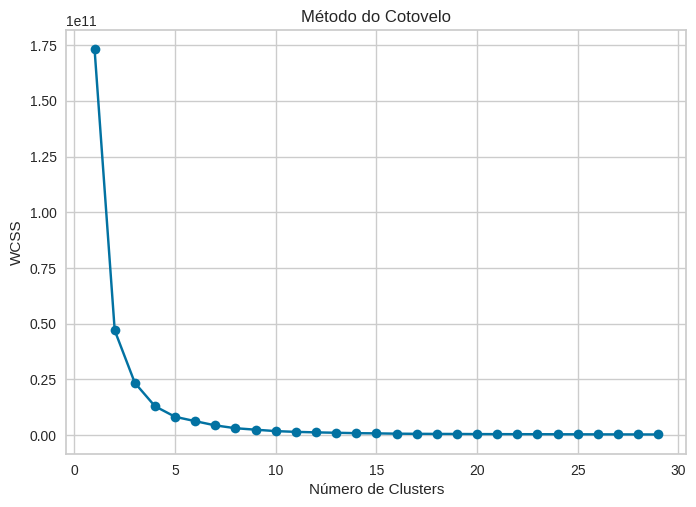

In [ ]:
# Remover colunas de data/hora antes de aplicar o KMeans
data_standardized = data_standardized.select_dtypes(include=['float64', 'int64'])

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Supondo que você já tenha os dados padronizados no DataFrame `data_standardized`

# Lista para armazenar a soma dos quadrados dentro dos clusters (WCSS)
wcss = []

# Testar diferentes números de clusters, por exemplo, de 1 a 30 clusters
for i in range(1, 30):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(data_standardized)
    wcss.append(kmeans.inertia_)

# Plotar o gráfico do cotovelo
plt.plot(range(1, 30), wcss, marker='o')
plt.title('Método do Cotovelo')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')
plt.show()

Método Silhueta

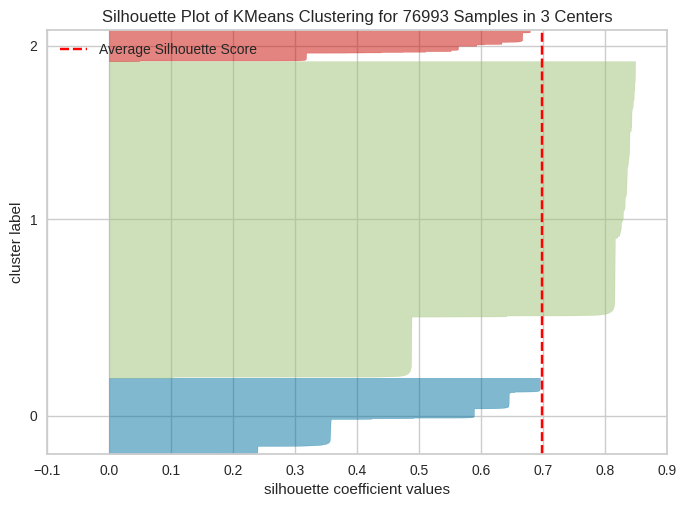

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 76993 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans

# Defina o número de clusters com base no método do cotovelo, por exemplo, 3 clusters
n_clusters = 3

# Crie e configure o modelo KMeans
kmeans_model = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300, random_state=42)

# Visualizador de silhueta usando o modelo KMeans
visualizer = SilhouetteVisualizer(kmeans_model, colors='yellowbrick')

# Ajuste o visualizador ao data_standardized
visualizer.fit(data_standardized)

# Exiba o gráfico da silhueta
visualizer.show()

Método Silhueta com 5 clusters

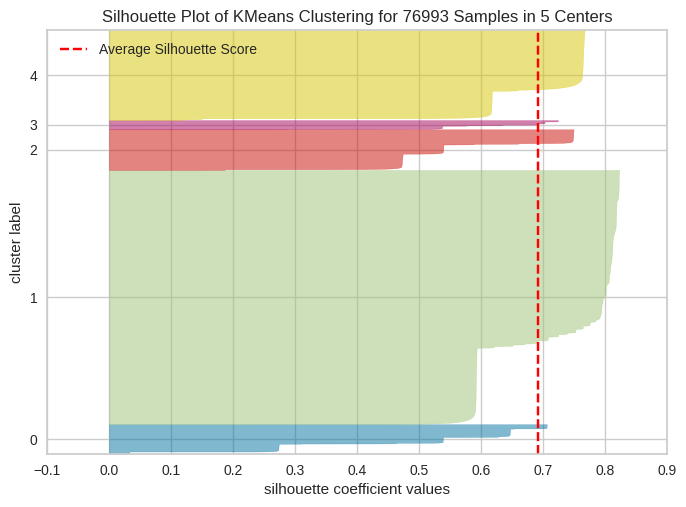

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 76993 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans

# Defina o número de clusters com base no método do cotovelo, por exemplo, 3 clusters
n_clusters = 5

# Crie e configure o modelo KMeans
kmeans_model = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300, random_state=42)

# Visualizador de silhueta usando o modelo KMeans
visualizer = SilhouetteVisualizer(kmeans_model, colors='yellowbrick')

# Ajuste o visualizador ao data_standardized
visualizer.fit(data_standardized)

# Exiba o gráfico da silhueta
visualizer.show()